In [6]:
import pandas as pd
from darts import TimeSeries

In [20]:
df = pd.read_csv('AirPassengers.csv', encoding='latin1')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [22]:
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

In [26]:
series

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

 We then build a (univariate) TimeSeries, specifying the time and value columns (Month and #Passengers, respectively).

Let’s now split our series in a training and validation TimeSeries, and train an exponential smoothing model on the training series:

In [32]:
from darts.models import ExponentialSmoothing

train, val = series.split_before(pd.Timestamp('19580101'))

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

That’s it, we now have a prediction over our validation series. We can plot it, along with the actual series:

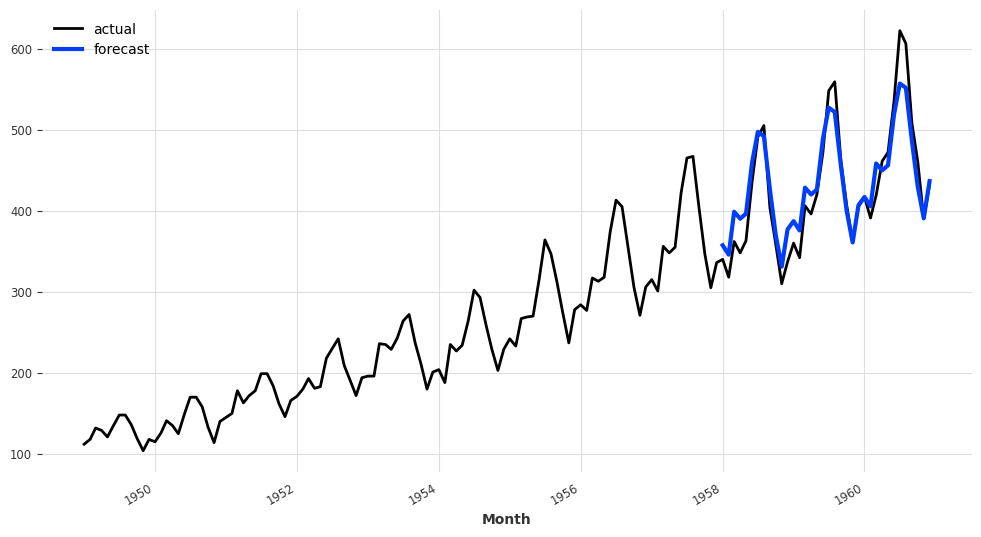

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

That’s all it takes. Note that the plot contains confidence intervals. By default, if a TimeSeries is probabilistic, Darts will show its 5th and 95th percentiles (here the series is probabilistic because we called predict() with num_samples=500).

A Few More Details
As you may have guessed, we are mimicking the scikit-learn fit() and predict()pattern for training models and making forecasts. The fit()function takes in argument a training TimeSeries and the predict() function returns a new TimeSeries representing the forecast. This means that models manipulate TimeSeries, and this is pretty much the only data type being manipulated in Darts. This allows users to easily swap and compare models. For example, we could have just as easily used an auto-ARIMA model (which behind the scenes wraps around pmdarima):

In [51]:
from darts.models import AutoARIMA

model_aarima = AutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

Basically, Darts is based on the following simple principles:

There are two kinds of models. Forecasting models predict the future values of a time series given the past values, and regression models predict values of a target time series given a set of feature time series. The exponential smoothing and auto-ARIMA model we built above are examples of forecasting models.
Unified fit() and predict() interface across all forecasting models, from ARIMA to neural networks.
Models consume and produce TimeSeries, which means for instance that it is easy to have a regression model consume the output of a forecasting model.
TimeSeries can be either univariate (1-dimensional) or multivariate (multi-dimensional). Certain models such as those based on neural nets operate on multivariate series, while others are restricted to univariate series.
Immutability: the TimeSeries class is designed to be immutable.

Another Example — Backtesting
In our example above, we used Darts to obtain once a forecast over the next 36 months starting in January 1958. However, forecasts often need to be updated as soon as new data becomes available. With Darts, it’s easy to compute the forecasts resulting from such a process, using backtesting. For instance, using backtesting to compare two models looks as follows:

In [73]:
models = [ExponentialSmoothing()]

backtests = [model.historical_forecasts(series,
                            start=.5,
                            forecast_horizon=3)
             for model in models]

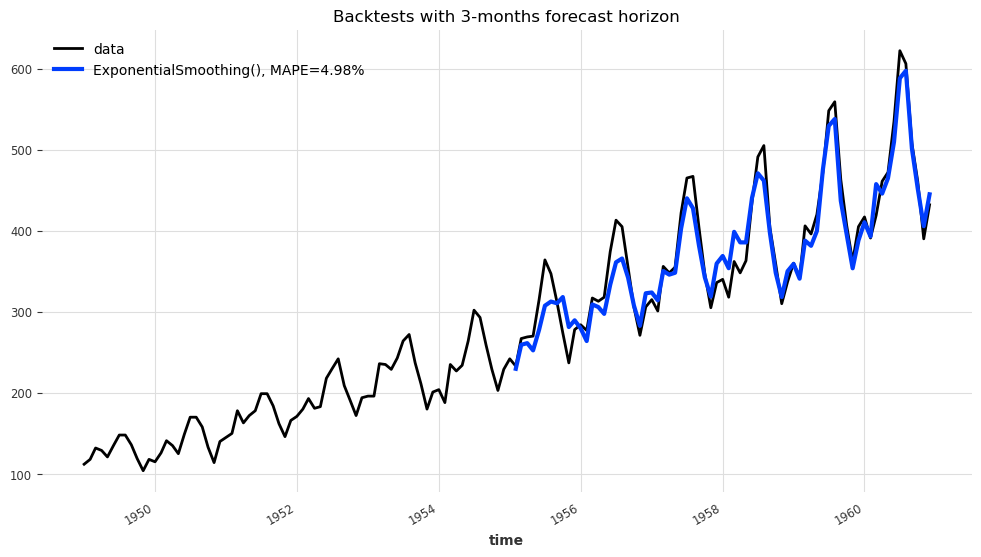

In [77]:
from darts.metrics import mape

plt.figure(figsize=(12,6))
series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 3-months forecast horizon')
plt.legend()